# Basic Visualization and Preprocessing

In [12]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False


In [13]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip', 
    extract=True)
csv_path, _ = os.path.splitext(zip_path)


Start by sub-sampling the data from 10-minute intervals to one-hour intervals:

In [14]:
df = pd.read_csv('jena_climate_2009_2016.csv') # pd.read_csv(csv_path) wasn't working for some reason
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [15]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Here's a basic view of three variables: Temperature in Celsius, Pressure in millibars, and density in g/m**3

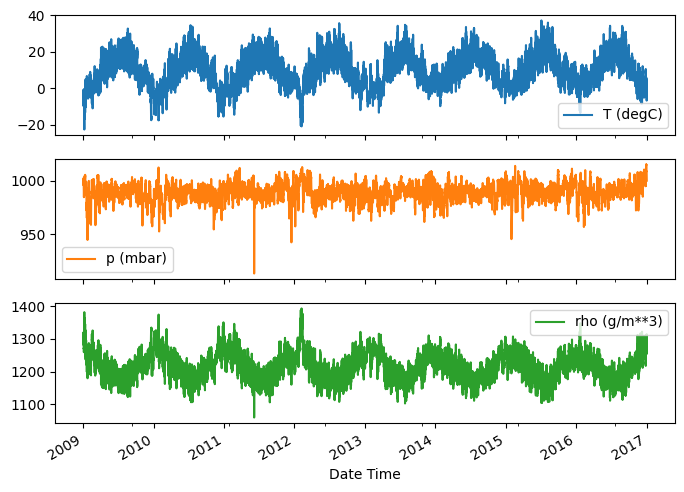

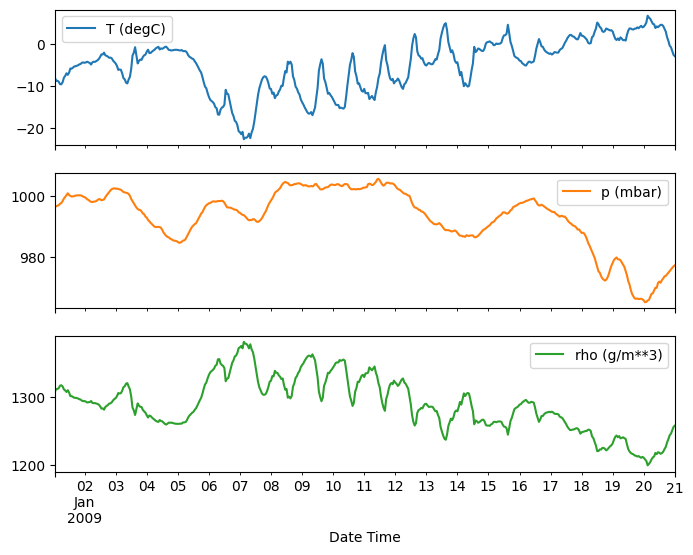

In [16]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

Next, look at the statistics of the dataset and see what you can infer:

In [17]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


Those -9999's in `wv` and `max. wv` rows look suspect. Let's clean them up.

In [18]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame:
df['max. wv (m/s)'].min()

np.float64(0.0)

# Feature Engineering

You must understand your data to be sure that you're passing the model appropriately-formatted data.

First off, *periodic* inputs such as angles don't make good inputs. Here's the current wind distribution:

Text(0, 0.5, 'Wind Velocity (m/s)')

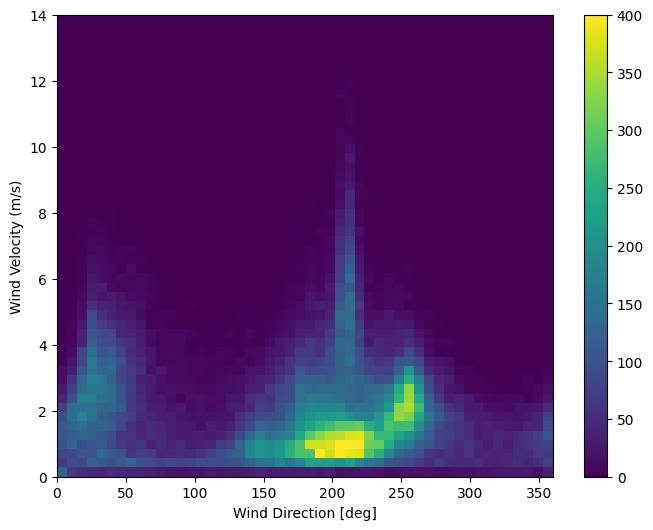

In [19]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50,50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity (m/s)')

Easier for the model if you make the direction/velocity columns into a single **wind vector**.

In [20]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians:
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components:
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Do the same for max_wind:
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

In [21]:
df['max Wx'].describe()

count    70091.000000
mean        -1.018681
std          3.095279
min        -19.641473
25%         -2.469210
50%         -1.117029
75%          0.627619
max         11.913133
Name: max Wx, dtype: float64

This should be much easier for the model to interpret:

(np.float64(-11.305513973134667),
 np.float64(8.24469928549079),
 np.float64(-8.27438540335515),
 np.float64(7.7338312955467785))

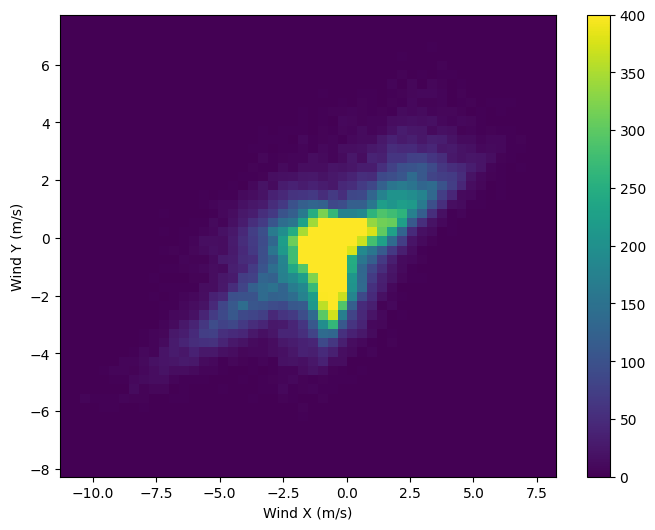

In [22]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50,50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X (m/s)')
plt.ylabel('Wind Y (m/s)')
ax = plt.gca()
ax.axis('tight')

Now we have to to make the Date Time column more useful. Convert it into seconds:

In [23]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

...except time in seconds is not useful?! Weather has daily & yearly periodicity. Get usable signals by transforming these seconds to clear "Time of Day" & "Time of Year" signals: $$\forall x \in \text{timestamp\_s}\;(x \mapsto \sin(\frac{2\pi x}{\text{day}}))$$

In [24]:
day = 24*60*60
year = 365.2425*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of Day signal')

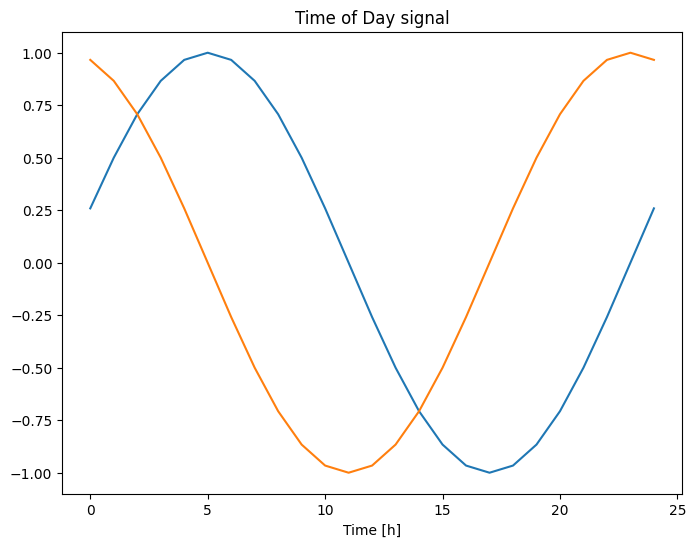

In [25]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel("Time [h]")
plt.title("Time of Day signal")

Here's a Fast Fourier Transform, used to find the important frequencies for the above sine and cosine transformations:

W0000 00:00:1743221183.176742  222588 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


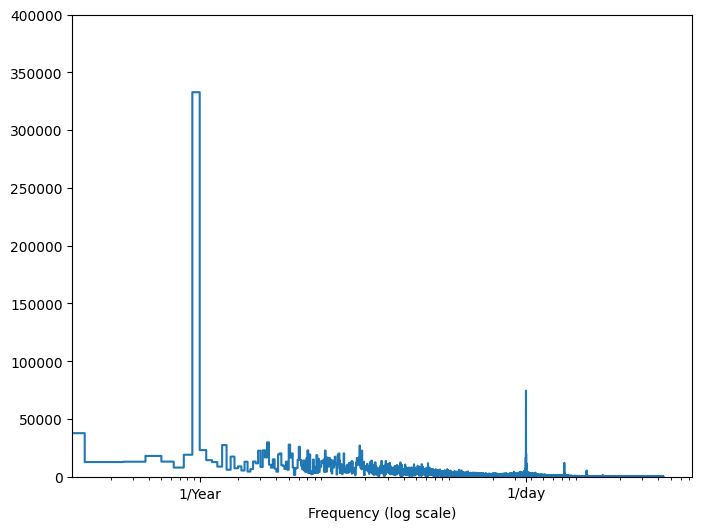

In [26]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2425
years_per_dataset = n_samples_h/hours_per_year

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim(0.1, max(plt.xlim()))
plt.xticks([1, 365.2425], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

# Split the data


70-20-10 Training, validation, test sets.

In [27]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.9)] # 70
val_df = df[int(n*0.7):int(n*0.9)]  # 20
test_df = df[int(n*0.9):] # 10

num_features = df.shape[1]
num_features

19

# Normalize the data


For simplicity, use simple average&mdash;should be done using a moving average.

In [28]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std


Peek at the distribution of the features:

/tmp/ipykernel_222588/622527561.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


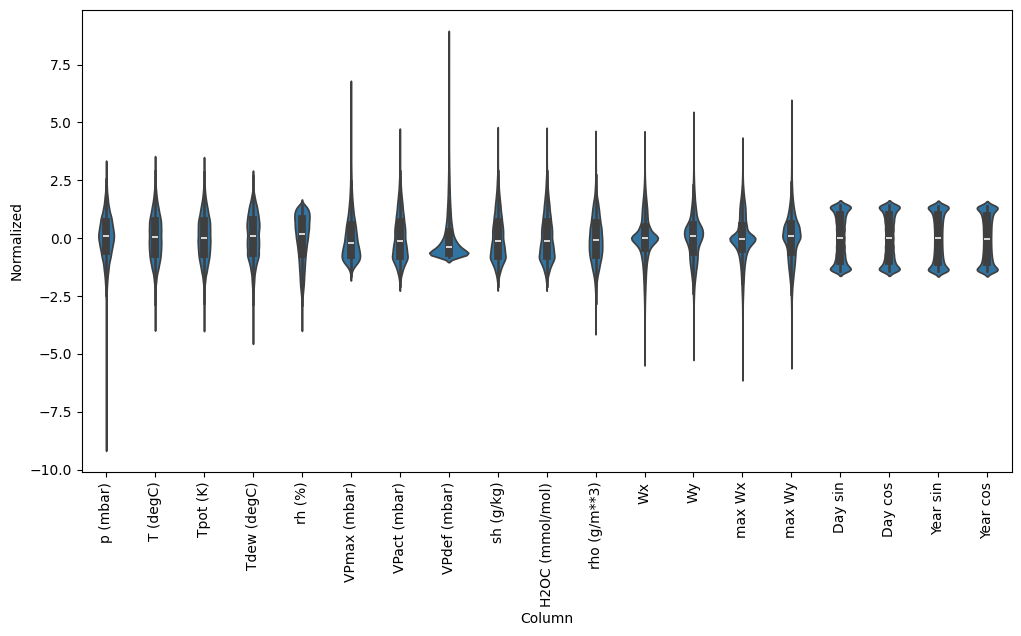

In [29]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12,6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# Data Windowing

Make a set of predictions based on a window of consecutive samples from the data. Window the data so it can be reused in many models.

## 1. Indices & offsets

In [41]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=None):
        # Store the raw data:
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df 
         
        # Work out the label column indices:
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        # Work out the window parameters:
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}', 
            f'Label indices: {self.label_indices}', 
            f'Label column name(s) {self.label_columns}'
        ])

In [42]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s) ['T (degC)']

In [43]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns='T (degC)')
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s) T (degC)

## 2. Split